In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, concatenate
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.models import Model
from keras.utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from IPython.display import SVG

from keras import backend as K

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


## Load Full TCGA data

In [2]:
X_train = pd.read_csv("data/tcga_filtered_scaled_all.csv")

In [3]:
tumor_type = pd.read_csv("data/tcga_tumor_type.csv")
y_tumor_type = pd.get_dummies(tumor_type)

In [5]:
y_tumor_type

,tumor_type_ACC,tumor_type_BLCA,tumor_type_BRCA,tumor_type_CESC,tumor_type_CHOL,tumor_type_COAD,tumor_type_COADREAD,tumor_type_DLBC,tumor_type_ESCA,tumor_type_GBM,...,tumor_type_READ,tumor_type_SARC,tumor_type_SKCM,tumor_type_STAD,tumor_type_TGCT,tumor_type_THCA,tumor_type_THYM,tumor_type_UCEC,tumor_type_UCS,tumor_type_UVM
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Initialize variables and hyperparameters

In [6]:
train_cond = pd.DataFrame(0, index=np.arange(30), columns=y_tumor_type.columns)
train_cond["tumor_type_BRCA"]=1

test_cond = pd.DataFrame(0, index=np.arange(10), columns=y_tumor_type.columns)
test_cond["tumor_type_BRCA"]=1

In [7]:
original_dim = X_train.shape[1]
cond_dim = y_tumor_type.shape[1]
input_shape = (original_dim,)
cond_shape = (cond_dim,)
intermediate_dim = 100
latent_dim = 100

batch_size = 100
epochs = 100
learning_rate = 0.001

## Define functions

In [8]:
def sampling(args):
    
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean_encoded + K.exp(0.5 * z_log_var_encoded) * epsilon

def vae_loss(y_true, y_pred):
    # E[log P(X|z)]
    reconstruction_loss = original_dim * binary_crossentropy(y_true, y_pred) # because it returns the mean cross-entropy
    # reconstruction_loss = mse(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl_loss = -0.5 * K.sum(1. + z_log_var_encoded - K.exp(z_log_var_encoded) - K.square(z_mean_encoded), axis=1)

    return K.mean(reconstruction_loss + kl_loss)

## Build Encoder

In [9]:
input_data = Input(shape=input_shape, name='encoder_input')
cond = Input(shape=cond_shape, name='condition_input')

inputs = concatenate([input_data, cond])

hidden_dense = Dense(intermediate_dim)(inputs)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense)
hidden_dense_encoded = Activation('relu')(hidden_dense_batchnorm)

z_mean_dense = Dense(latent_dim, name='z_mean_dense')(hidden_dense_encoded)
z_log_var_dense = Dense(latent_dim, name='z_log_var_dense')(hidden_dense_encoded)

z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_encoded, z_log_var_encoded])
z_cond = concatenate([z, cond])

encoder = Model([input_data, cond], [z_mean_encoded, z_log_var_encoded, z_cond], name='encoder')
encoder.summary()

# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 17363)        0                                            
__________________________________________________________________________________________________
condition_input (InputLayer)    (None, 35)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 17398)        0           encoder_input[0][0]              
                                                                 condition_input[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1739900     concatenate_1[0][0]              
__________

## Build Decoder 

In [10]:
decoder_hidden = Dense(intermediate_dim, activation='relu', name='decoder_hidden')
decoder_outputs = Dense(input_shape[0], activation='sigmoid', name='decoder_output')

# Build structure for VAE
vae_decoder_hidden = decoder_hidden(z_cond)
outputs = decoder_outputs(vae_decoder_hidden)

# Build structure for Decoder
decoder_input = Input(shape=(latent_dim+cond_dim,), name='z_sampling')

x_hidden = decoder_hidden(decoder_input)
x_decoded = decoder_outputs(x_hidden)

decoder = Model(decoder_input, x_decoded, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 135)               0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 100)               13600     
_________________________________________________________________
decoder_output (Dense)       (None, 17363)             1753663   
Total params: 1,767,263
Trainable params: 1,767,263
Non-trainable params: 0
_________________________________________________________________


## Build Variational Autoencoder

In [11]:
#outputs = decoder(encoder(inputs)[2]) # fetches the z layer, the sampled one concatenated with the condition
vae = Model([input_data, cond], outputs, name='vae')

adam = optimizers.Adam(lr=learning_rate)

vae.compile(optimizer=adam, loss=vae_loss)
vae.summary()

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 17363)        0                                            
__________________________________________________________________________________________________
condition_input (InputLayer)    (None, 35)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 17398)        0           encoder_input[0][0]              
                                                                 condition_input[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1739900     concatenate_1[0][0]              
__________

## Train the Model

In [ ]:
#Split validation set
test_set_percent = 0.1
X_autoencoder_val = X_autoencoder_scaled.sample(frac=test_set_percent)
X_autoencoder_train = X_autoencoder_scaled.drop(X_autoencoder_val.index)

X_autoencoder_val_cond = X_autoencoder_scaled.sample(frac=test_set_percent)
X_autoencoder_train_cond = X_autoencoder_scaled.drop(X_autoencoder_val.index)

In [12]:
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=10, inter_op_parallelism_threads=10)))

fit_hist = vae.fit([X_train, X_autoencoder_train_cond], X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10), tensorboard],
        validation_data=([X_autoencoder_val, X_autoencoder_val_cond], X_autoencoder_val))

Train on 10435 samples, validate on 1160 samples
Epoch 1/100
10435/10435 [==============================] - 27s 3ms/step - loss: 10358.0726 - val_loss: 10207.3921
Epoch 2/100
10435/10435 [==============================] - 23s 2ms/step - loss: 10009.9822 - val_loss: 10076.6162
Epoch 3/100
10435/10435 [==============================] - 25s 2ms/step - loss: 9960.2795 - val_loss: 10037.5198
Epoch 4/100
10435/10435 [==============================] - 25s 2ms/step - loss: 9932.3241 - val_loss: 10017.8922
Epoch 5/100
10435/10435 [==============================] - 25s 2ms/step - loss: 9913.9794 - val_loss: 9989.0671
Epoch 6/100
10435/10435 [==============================] - 24s 2ms/step - loss: 9902.9175 - val_loss: 9997.1913
Epoch 7/100
10435/10435 [==============================] - 26s 2ms/step - loss: 9892.6580 - val_loss: 10002.4631
Epoch 8/100
10435/10435 [==============================] - 26s 2ms/step - loss: 9884.5631 - val_loss: 9976.5732
Epoch 9/100
10435/10435 [=======================

## Visualize training performance

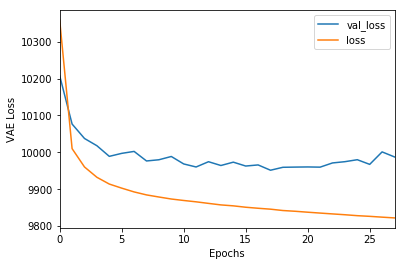

In [13]:
history_df = pd.DataFrame(fit_hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()

## Train Logistic Regression Classifier

In [12]:
encoded_train_data = encoder.predict(X_brca_train_scaled)
encoded_train_data = pd.DataFrame(encoded_train_data[0])

encoded_test_data = encoder.predict(X_brca_test_scaled)
encoded_test_data = pd.DataFrame(encoded_test_data[0])

In [16]:
cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
scores=[]
for c in cs:
    clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l2", C=c, multi_class="auto").fit(encoded_train_data, y_brca_train)
    aux=clf.score(encoded_test_data, y_brca_test)
    scores.append(aux)
    print("C:{}, Accuracy:{}".format(c, aux))

C:0.001, Accuracy:0.5060975609756098
C:0.01, Accuracy:0.5060975609756098
C:0.1, Accuracy:0.6646341463414634
C:1, Accuracy:0.7621951219512195
C:10, Accuracy:0.774390243902439
C:100, Accuracy:0.7682926829268293
C:1000, Accuracy:0.774390243902439
C:10000, Accuracy:0.75
